<a href="https://colab.research.google.com/github/Tharun-R-Git/DSD-ALL-IN-ONE/blob/main/Copy_of_Build_a_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build a Generative Adversarial Network

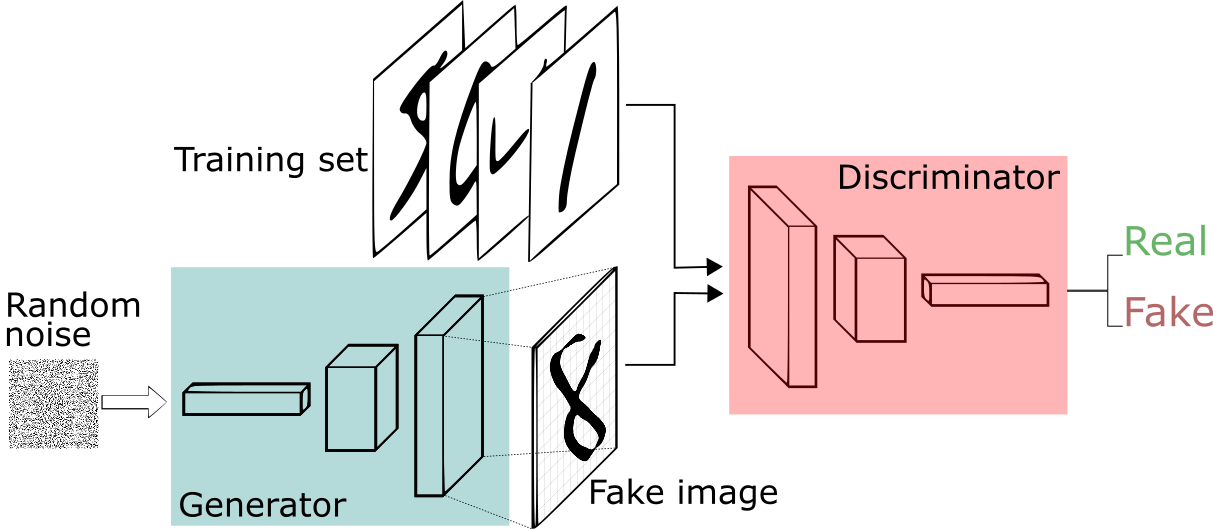

In [25]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [26]:
device = 'cuda'      #image = image.to(device)
batch_size = 128   #trainloader, training loop
noise_dim = 64     #generator model

#optimisers parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#training variables
epochs = 20



# Load MNIST Dataset

In [27]:
from torchvision import datasets, transforms as T


In [28]:
train_augs = T.Compose([
    T.RandomRotation((-20,20)),
    T.ToTensor()  # (h,w,c) -> (c,h,w)
])

In [31]:
trainset = datasets.MNIST('MNIST/',download=True, train = True, transform = train_augs)

Total images present in trainset =  60000


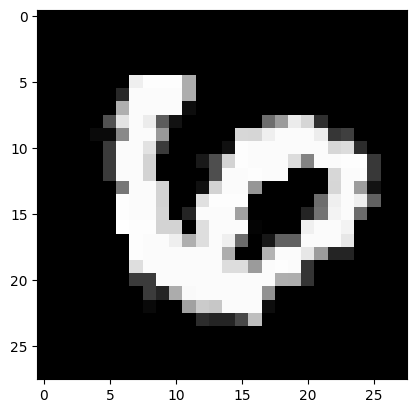

In [30]:
image , label = trainset[9000]
plt.imshow(image.squeeze(),cmap='gray')

print("Total images present in trainset = ",len(trainset))

# Load Dataset Into Batches

In [32]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


In [33]:
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True)
print("Total number of batches in trainloader: ",len(trainloader))

Total number of batches in trainloader:  469


In [34]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)


torch.Size([128, 1, 28, 28])


In [35]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

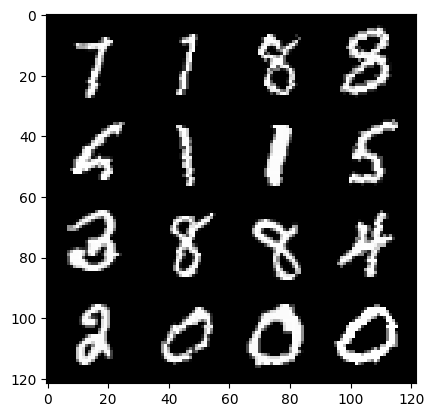

In [36]:
show_tensor_images(images, num_images=16)

# Create Discriminator Network

In [37]:
#In case if torch summary is not installed

!pip install torchsummary

In [38]:
from torch import nn
from torchsummary import summary

In [39]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [40]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)

  )

In [41]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.block_1=get_disc_block(1,16,(3,3),2)
    self.block_2=get_disc_block(16,32,(5,5),2)
    self.block_3=get_disc_block(32,64,(5,5),2)
    self.flatten=nn.Flatten()
    self.linear=nn.Linear(in_features=64,out_features=1)

  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5




In [42]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [48]:
def get_gen_block(in_channels,out_channels,kernel_size,stride,final_block=False):
  if final_block==True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()

  )

In [49]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()
    self.noise_dim=noise_dim
    self.block_1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)
    self.block_4 = get_gen_block(64,1,(4,4),2,final_block=True)

  def forward(self,r_noise_vec):
    # bs,noise_dim -> bs,noise_dim,1,1
    x = r_noise_vec.view(-1, self.noise_dim,1,1)
    x1=self.block_1(x)
    x2=self.block_2(x1)
    x3=self.block_3(x2)
    x4=self.block_4(x3)

    return x4




In [50]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [51]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [53]:
D=D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [55]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

D_opt = torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_1,beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_Loss : 0.6838808386310585 | G_Loss : 0.6923198748244914


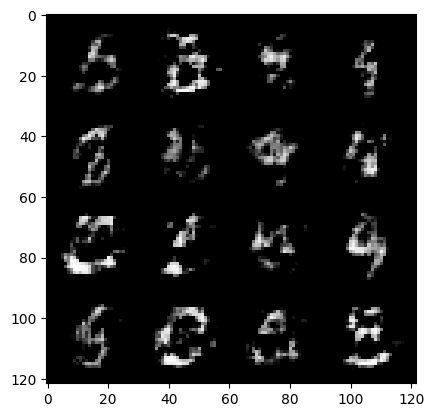

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_Loss : 0.6768159859978569 | G_Loss : 0.712721176111876


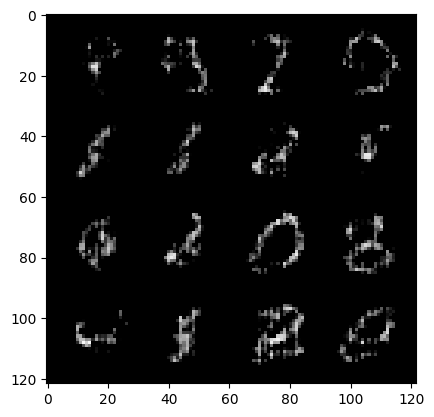

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_Loss : 0.6411148886690771 | G_Loss : 0.7513430892531552


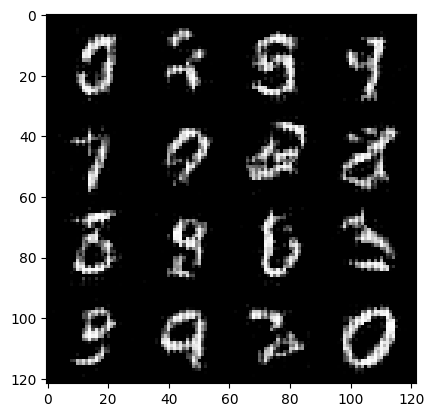

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_Loss : 0.6229388748150645 | G_Loss : 0.7790373434135909


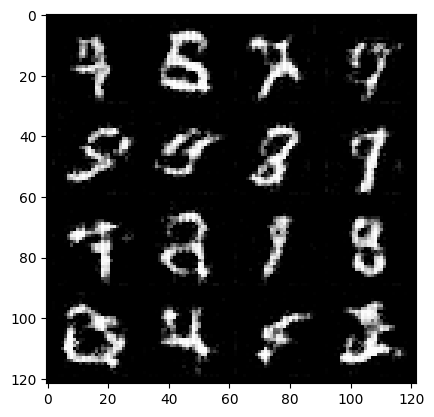

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_Loss : 0.6260895113955175 | G_Loss : 0.7840506668283995


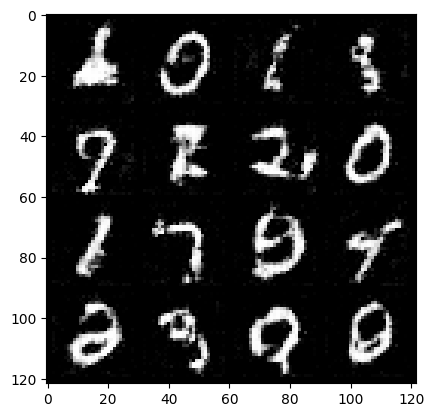

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_Loss : 0.6315928818320414 | G_Loss : 0.7865822879490314


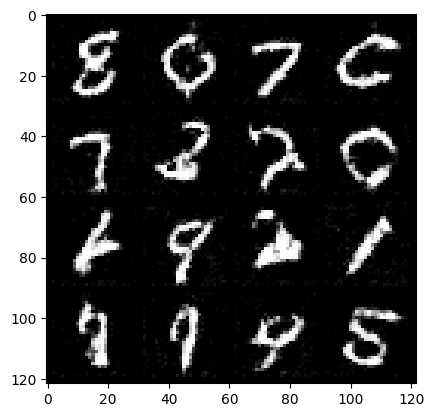

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_Loss : 0.6330631469358513 | G_Loss : 0.7897717037688948


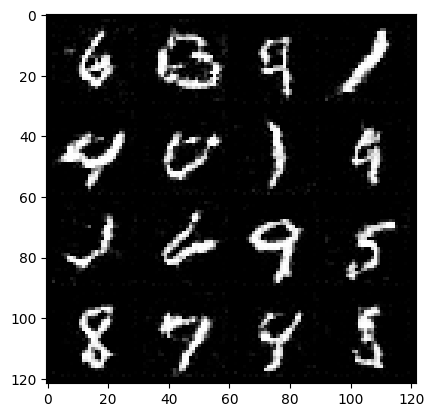

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_Loss : 0.6359095795830684 | G_Loss : 0.7917179580944688


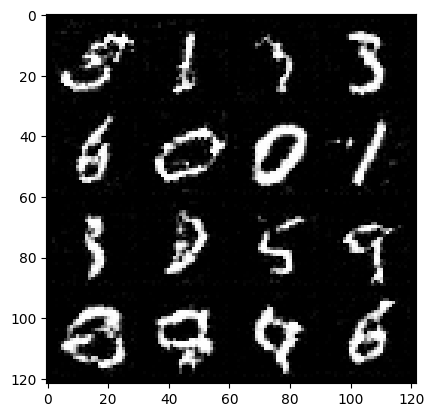

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_Loss : 0.6416121873774254 | G_Loss : 0.7883624203169524


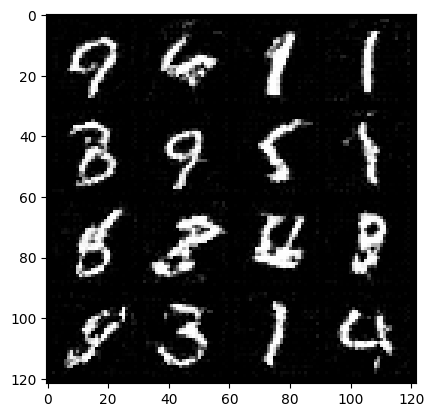

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_Loss : 0.6461368891984415 | G_Loss : 0.7849031323308884


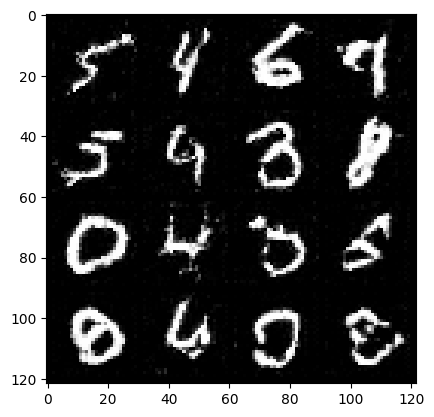

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_Loss : 0.6509642740810858 | G_Loss : 0.7825810431417372


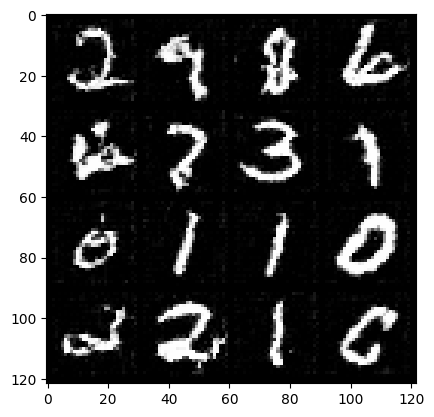

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_Loss : 0.65268198424565 | G_Loss : 0.7779881045508232


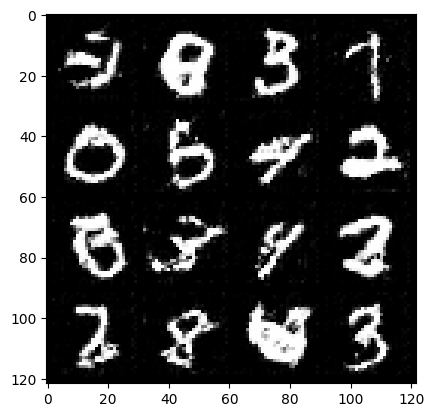

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_Loss : 0.6541913521569421 | G_Loss : 0.7791674720453047


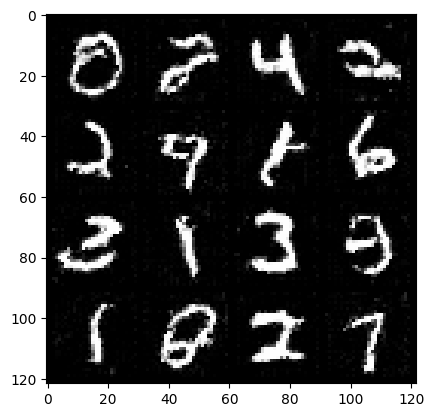

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_Loss : 0.6543997890913664 | G_Loss : 0.7789982362850897


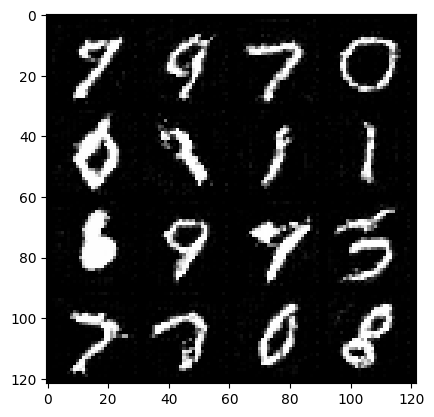

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_Loss : 0.6552942053341408 | G_Loss : 0.7778988846583661


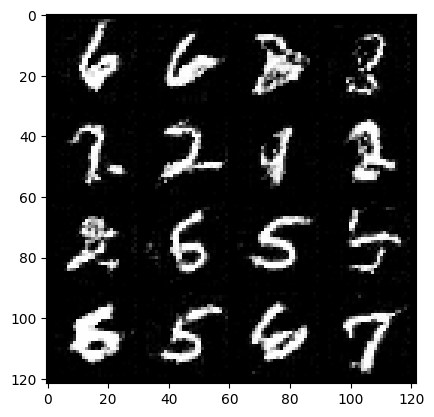

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_Loss : 0.6574047266293183 | G_Loss : 0.7766520208133055


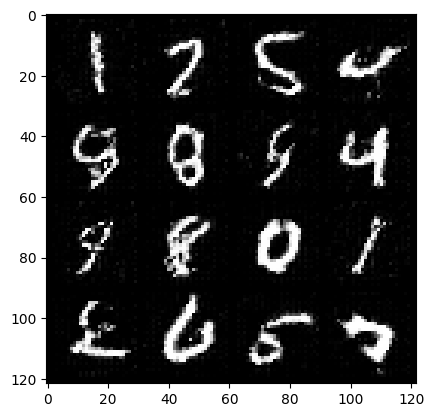

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_Loss : 0.6562786529313273 | G_Loss : 0.7771607115070449


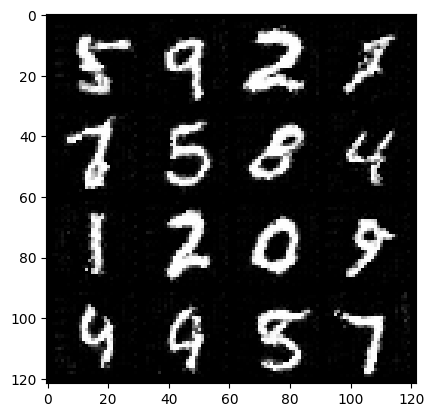

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_Loss : 0.6562367953471283 | G_Loss : 0.7778137666838509


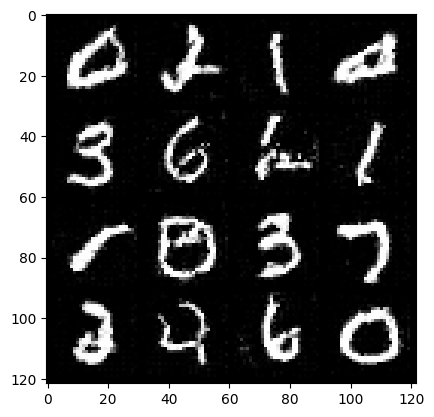

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_Loss : 0.6561680513658503 | G_Loss : 0.7806223939730923


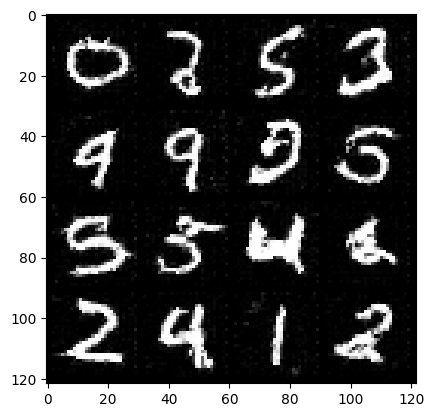

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_Loss : 0.657417888453266 | G_Loss : 0.7773430337275523


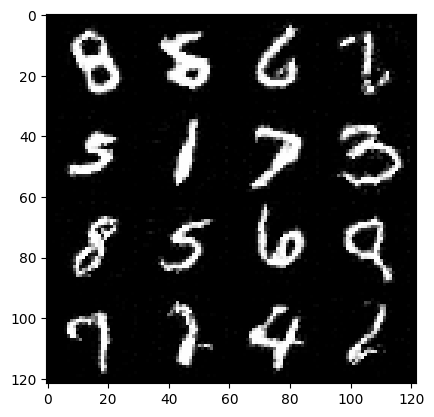

In [56]:
for i in range(epochs):
  total_d_loss,total_g_loss=0.0,0.0
  for real_img,_ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size,noise_dim, device = device)

    #find loss and update weights for D

    D_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)
    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)
    D_loss = (D_fake_loss+D_real_loss)/2

    total_d_loss += D_loss.item()
    D_loss.backward()
    D_opt.step()


    #find loss and update weights for G

    G_opt.zero_grad()
    noise = torch.randn(batch_size,noise_dim,device=device)
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch : {} | D_Loss : {} | G_Loss : {}".format(i+1,avg_d_loss,avg_g_loss))

  show_tensor_images(fake_img)






In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya